In [1]:
%%capture
!pip install -q bitsandbytes
!pip install -q trl
!pip install -q peft

In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from kaggle_secrets import UserSecretsClient
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

# --- Transformers, PEFT, and Datasets Imports ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BitsAndBytesConfig, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training

2025-08-14 09:05:33.142046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755162333.357880      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755162333.421464      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

data_path = "/kaggle/input/nlp-stock-data/indo_raw_with_emoji.csv"
MODEL_NAME = "meta-llama/Llama-3.2-1B"
label_encoder = LabelEncoder()

In [4]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
os.environ['HF_TOKEN'] = hf_token
print("Hugging Face token found and set.")

Hugging Face token found and set.


In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Data Preparation

In [6]:
df = pd.read_csv(data_path)
df.dropna(subset=['Processed_Sentence', 'Sentiment'], inplace=True)

X = df['Processed_Sentence'].tolist()
y = label_encoder.fit_transform(df['Sentiment'])
NUM_LABELS = len(label_encoder.classes_)

print("Label mapping:", {i: label for i, label in enumerate(label_encoder.classes_)})

Label mapping: {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Data split - Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Data split - Train: 2301, Val: 493, Test: 494


In [8]:
train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
val_dataset = Dataset.from_dict({'text': X_val, 'label': y_val})
test_dataset = Dataset.from_dict({'text': X_test, 'label': y_test})

hf_datasets = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

# Tokenizer

In [9]:
print(f"\n--- Initializing model and tokenizer from '{MODEL_NAME}' ---")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=hf_token)
tokenizer.pad_token = tokenizer.eos_token # Set pad token

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=64)

tokenized_datasets = hf_datasets.map(tokenize_function, batched=True)


--- Initializing model and tokenizer from 'meta-llama/Llama-3.2-1B' ---


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

Map:   0%|          | 0/2301 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/494 [00:00<?, ? examples/s]

# Model

In [10]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    quantization_config=bnb_config,
    device_map="auto",
    token=hf_token
)

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Set pad token ID for the model config
model.config.pad_token_id = tokenizer.pad_token_id

# Prepare model for k-bit training
model = prepare_model_for_kbit_training(model)

## a) Lora Configuration

In [12]:
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)

lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 6,821,888 || all params: 1,242,642,432 || trainable%: 0.5490


## b) Training

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    return {
        'accuracy': accuracy, 
        'f1_macro': f1_macro
    }

In [14]:
training_args = TrainingArguments(
    output_dir='./llama_classification_results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [15]:
print("\n--- Evaluating Base Model (Before Training) ---")

baseline_eval_results = trainer.evaluate(eval_dataset=tokenized_datasets["validation"])
print("\nBaseline Evaluation Results:")
print(f"Accuracy: {baseline_eval_results.get('eval_accuracy', 'N/A'):.4f}")
print(f"F1-Macro: {baseline_eval_results.get('eval_f1_macro', 'N/A'):.4f}")


--- Evaluating Base Model (Before Training) ---



Baseline Evaluation Results:
Accuracy: 0.4503
F1-Macro: 0.2607


In [16]:
print("\n--- Starting Model Training ---")
trainer.train()


--- Starting Model Training ---


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1 Macro
1,0.978100,0.635120,0.003000,0.758621,0.703860
2,0.462200,0.581012,0.003000,0.784990,0.747378
3,0.238900,0.863254,0.003000,0.811359,0.779873
4,0.086500,1.161125,0.003000,0.805274,0.777700
5,0.016300,1.172752,0.003000,0.815416,0.791334


TrainOutput(global_step=1440, training_loss=0.3563761701186498, metrics={'train_runtime': 1273.7028, 'train_samples_per_second': 9.033, 'train_steps_per_second': 1.131, 'total_flos': 4329447370260480.0, 'train_loss': 0.3563761701186498, 'epoch': 5.0})

# Evaluation

In [17]:
def evaluate_classification_model(trainer, tokenized_dataset, dataset_name):
    print(f"\n--- {dataset_name} Results ---")
    predictions_output = trainer.predict(tokenized_dataset)
    y_pred = np.argmax(predictions_output.predictions, axis=1)
    y_true = tokenized_dataset['label']

    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Macro: {f1_macro:.4f}")
    print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'predictions': y_pred,
        'classification_report': classification_report(
            y_true, y_pred, target_names=label_encoder.classes_, digits=4, output_dict=True
        )
    }

In [18]:
train_results = evaluate_classification_model(trainer, tokenized_datasets['train'], "Train")
val_results = evaluate_classification_model(trainer, tokenized_datasets['validation'], "Validation")
test_results = evaluate_classification_model(trainer, tokenized_datasets['test'], "Test")

print("\n=== F1-Macro Summary ===")
print(f"Train F1-Macro: {train_results['f1_macro']:.4f}")
print(f"Validation F1-Macro: {val_results['f1_macro']:.4f}")
print(f"Test F1-Macro: {test_results['f1_macro']:.4f}")


--- Train Results ---


Accuracy: 0.9978
F1-Macro: 0.9975
              precision    recall  f1-score   support

    Negative     1.0000    0.9982    0.9991       550
     Neutral     0.9980    0.9922    0.9951       513
    Positive     0.9968    1.0000    0.9984      1238

    accuracy                         0.9978      2301
   macro avg     0.9983    0.9968    0.9975      2301
weighted avg     0.9978    0.9978    0.9978      2301


--- Validation Results ---


Accuracy: 0.8154
F1-Macro: 0.7913
              precision    recall  f1-score   support

    Negative     0.8067    0.8136    0.8101       118
     Neutral     0.7327    0.6727    0.7014       110
    Positive     0.8498    0.8755    0.8625       265

    accuracy                         0.8154       493
   macro avg     0.7964    0.7873    0.7913       493
weighted avg     0.8134    0.8154    0.8140       493


--- Test Results ---


Accuracy: 0.8279
F1-Macro: 0.8022
              precision    recall  f1-score   support

    Negative     0.8173    0.7203    0.7658       118
     Neutral     0.7350    0.7818    0.7577       110
    Positive     0.8718    0.8947    0.8831       266

    accuracy                         0.8279       494
   macro avg     0.8080    0.7990    0.8022       494
weighted avg     0.8283    0.8279    0.8272       494


=== F1-Macro Summary ===
Train F1-Macro: 0.9975
Validation F1-Macro: 0.7913
Test F1-Macro: 0.8022


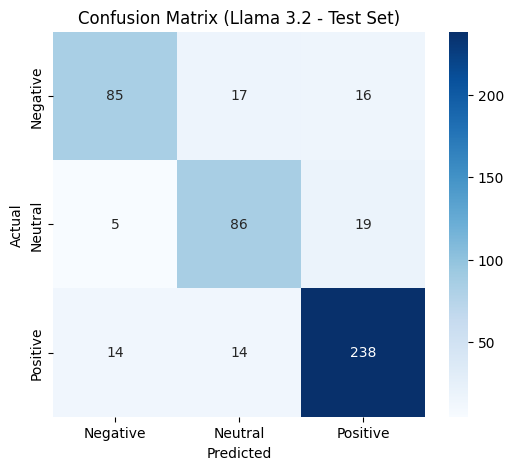

In [19]:
cm = confusion_matrix(y_test, test_results['predictions'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title(f'Confusion Matrix (Llama 3.2 - Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
wrong_pred_indices = np.where(y_test != test_results['predictions'])[0]

wrong_predictions_df = pd.DataFrame({
    'Sentence': [X_test[i] for i in wrong_pred_indices],
    'Actual Sentiment': label_encoder.inverse_transform(y_test[wrong_pred_indices]),
    'Predicted Sentiment': label_encoder.inverse_transform(test_results['predictions'][wrong_pred_indices])
})

wrong_predictions_df.to_csv('wrong_predictions_Llama3_classifier.csv', index=False)

display(wrong_predictions_df.head())

,Sentence,Actual Sentiment,Predicted Sentiment
0,Bmri mumpung lg koreksi,Positive,Neutral
1,"Hari ini cum dividen ASRM (Rp 65), BIRD (Rp 72...",Neutral,Positive
2,"gatau mas, ta souvenir UNVR yg keren bagiku wk...",Neutral,Positive
3,Gara-gara tulisan ane tentang 3 saham problema...,Positive,Neutral
4,"cerita dikit pas awal awal kenal investasi,per...",Neutral,Negative
